In [1]:
import os, sys

import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from utils.time_utils import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# base_dir = "/n/holylabs/LABS/idreos_lab/Users/azhao/gpu_profiling"
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"

dtype_to_peak_fp = {
    "32": 19.5,
    "tf32": 156,
    "16": 312,
    "b16": 312
}

# MM

100%|██████████| 72/72 [00:49<00:00,  1.45it/s]


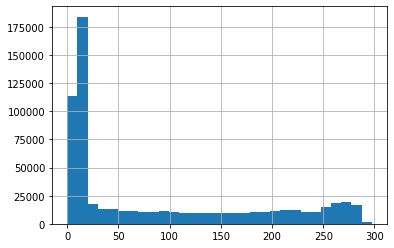

In [37]:
"""
Note: using final I/O is only a rough heuristic for data movement.
"""
time_processor_conv2d = TimeProcessorMM(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

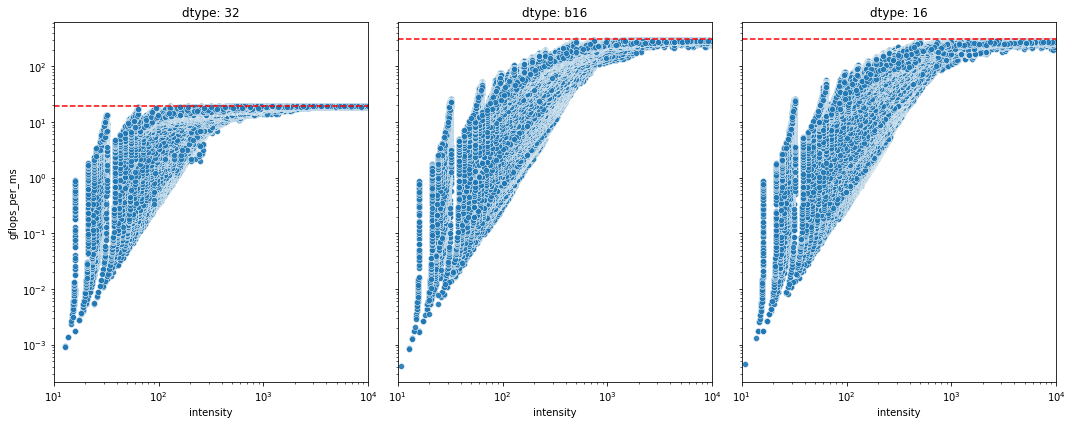

In [44]:

"""
If you compute the slope, for fp32, it's actually ~ 20 tflops/second, as described in
https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf.

For fp16 and fpb16, it's slightly less than the purported 312 tflops/second.

To see: change the xlim and xscale.
"""

df["memory_accesses"] = df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(["32", "b16", "16"]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}")
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")

ax.set_xlim(left = 10, right = 10**4)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# BMM

Similar amounts

100%|██████████| 72/72 [02:43<00:00,  2.27s/it]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<AxesSubplot:>

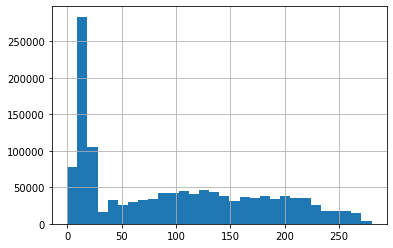

In [45]:
time_processor_conv2d = TimeProcessorBMM(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.1)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)

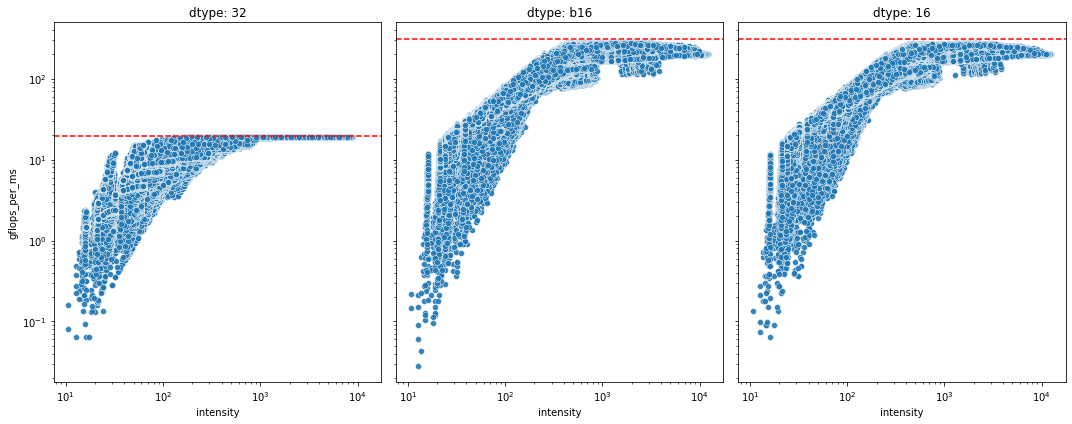

In [46]:
df["memory_accesses"] = df["b"] * (df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"])
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(["32", "b16", "16"]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}")
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# SDPA

16it [00:06,  2.34it/s]
100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


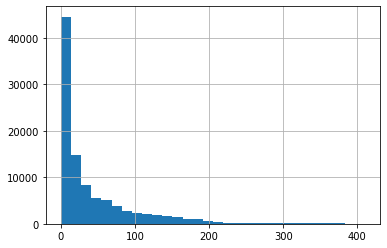

In [47]:
time_processor_sdpa = TimeProcessorSDPA(base_dir)
df = time_processor_sdpa.get_data(sample_rate=0.7)
df["gflops_per_ms"] = df["gflops"] / df["time"]
df["gflops_per_ms"].hist(bins=30)
plt.show()

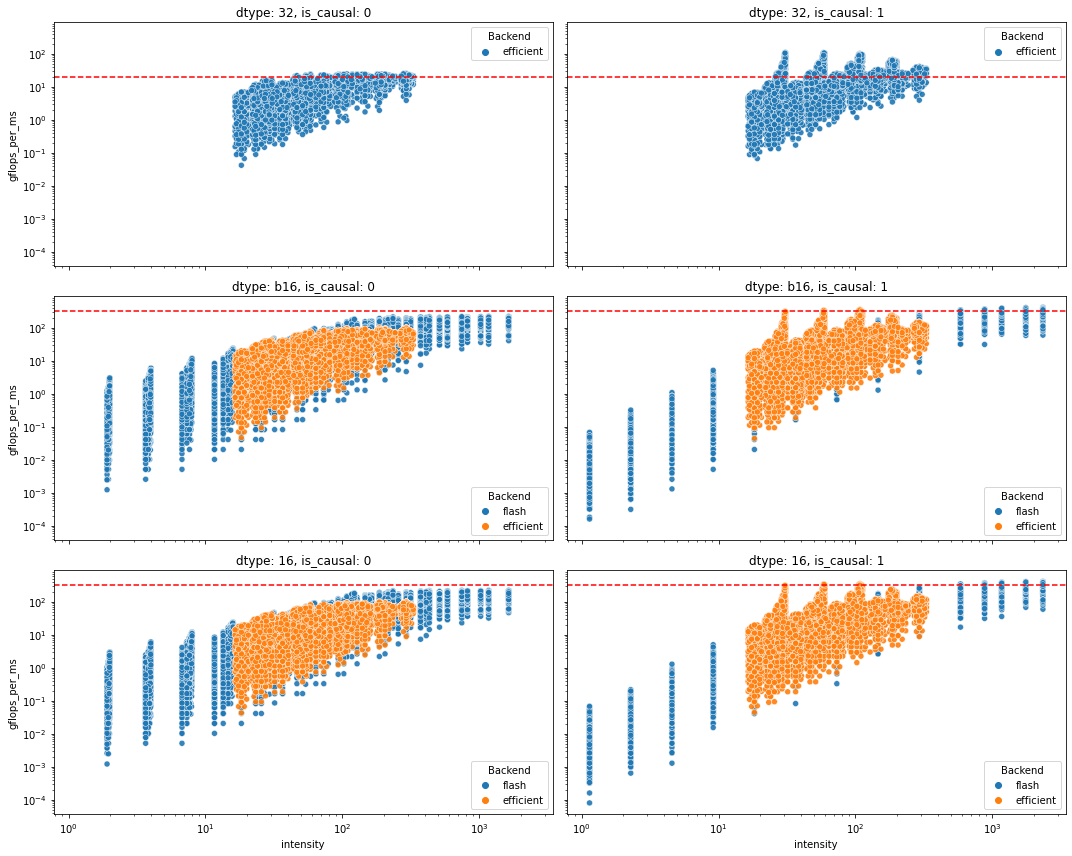

In [50]:
df["memory_accesses"] = (
    2 * df["b"] * df["h"] * df["s_q"] * df["d_qk"] +   # Reading Q
    2 * df["b"] * df["h"] * df["s_kv"] * df["d_qk"] +  # Reading K
    2 * df["b"] * df["h"] * df["s_kv"] * df["d_v"] +   # Reading V
    df["b"] * df["h"] * df["s_q"] * df["d_v"]      # Writing Output
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# SDPA Backward

In [6]:
time_processor_sdpa = TimeProcessorSDPA(base_dir, is_forward=False)
df = time_processor_sdpa.get_data(sample_rate=0.7)
df["gflops_per_ms"] = df["gflops"] / df["time"]
# df["gflops_per_ms"].hist(bins=30)
plt.show()

16it [00:05,  2.91it/s]
100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


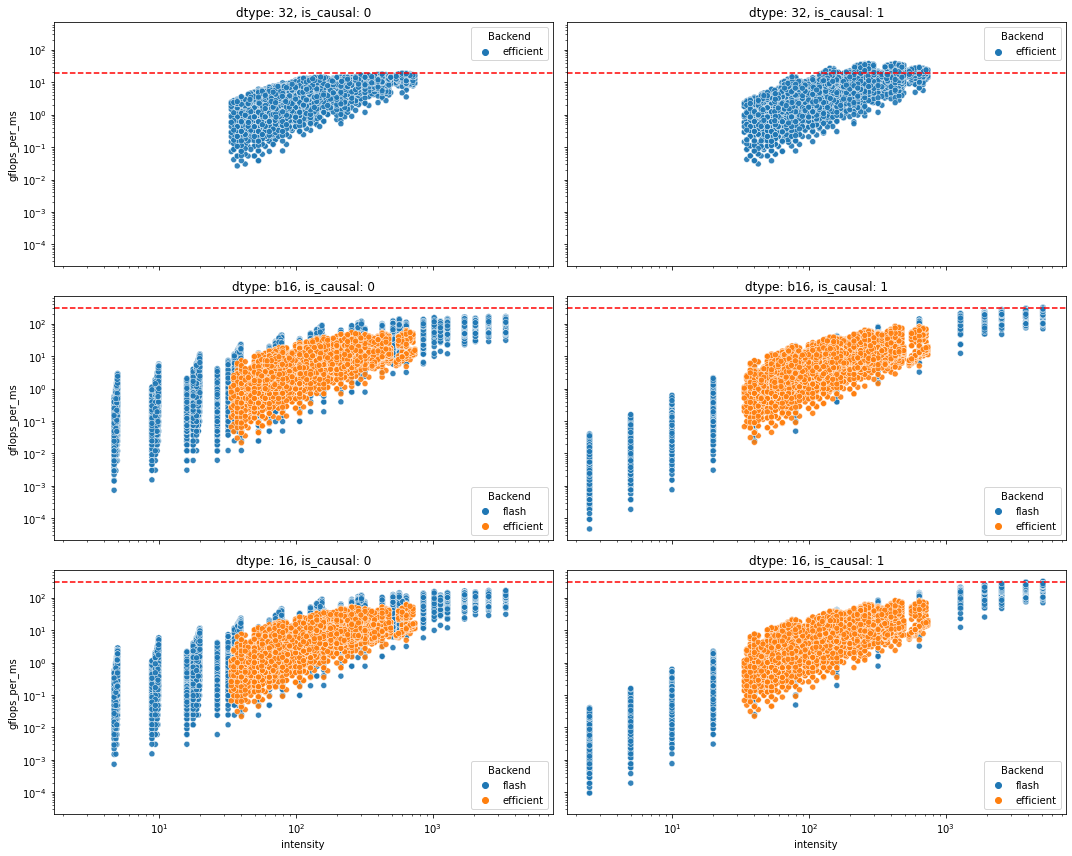

In [7]:
df["memory_accesses"] = 2 * (
    df["b"] * df["h"] * df["s_q"] * df["d_qk"] +  # dQ
    df["b"] * df["h"] * df["s_kv"] * df["d_qk"] +  # dK
    df["b"] * df["h"] * df["s_kv"] * df["d_v"] +   # dV
    df["b"] * df["h"] * df["s_q"] * df["d_v"]      # dOut
)
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, is_causal) in enumerate([(dtype, is_causal) for dtype in ["32", "b16", "16"] for is_causal in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", hue="backend", alpha=0.9, data=df.query(f"dtype == '{dtype}' and is_causal == '{is_causal}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, is_causal: {is_causal}")
    ax.legend(title="Backend", loc='best')
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")

ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Conv2d

In [7]:
time_processor_conv2d = TimeProcessorConv2d(base_dir)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
# df["gflops_per_ms"].hist(bins=30)
# plt.show()

34it [00:13,  1.12it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:18,  2.02it/s]

< 0 found in file time.128.512.0.pkl


46it [00:20,  1.76it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:24,  1.90it/s]

< 0 found in file time.512.128.0.pkl


56it [00:25,  1.54it/s]

< 0 found in file time.512.512.0.pkl


58it [00:26,  1.87it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:27,  1.30it/s]

< 0 found in file time.512.1024.1.pkl


64it [00:29,  2.02it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:30,  2.18it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:32,  1.72it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:33,  1.62it/s]

< 0 found in file time.1024.512.1.pkl


70it [00:33,  1.45it/s]

< 0 found in file time.1024.1024.0.pkl


71it [00:34,  1.45it/s]

< 0 found in file time.1024.1024.1.pkl


72it [00:34,  2.07it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:399: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


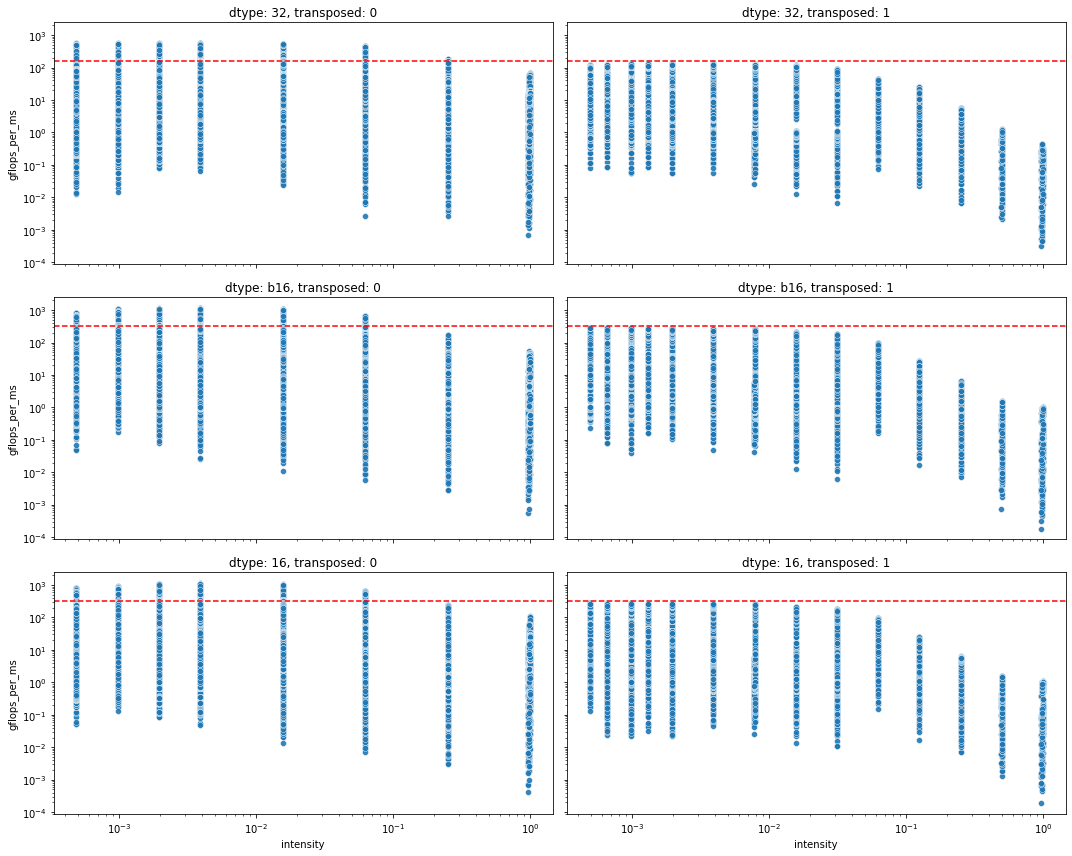

In [37]:
padding = 0
output_padding = 0

# Note: this is a heuristic.
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]
df["memory_accesses"] = input_memory_accesses + kernel_memory_accesses + output_memory_accesses

df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, transposed) in enumerate([(dtype, transposed) for dtype in ["32", "b16", "16"] for transposed in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}' and transposed == '{transposed}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, transposed: {transposed}")

    if dtype == "32":
        dtype = "tf32"
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")
    
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Conv2d Backward

In [2]:
time_processor_conv2d = TimeProcessorConv2d(base_dir, is_forward=False)
df = time_processor_conv2d.get_data(sample_rate=0.5)
df["gflops_per_ms"] = df["gflops"] / df["time"]
# df["gflops_per_ms"].hist(bins=30)
# plt.show()

0it [00:00, ?it/s]

34it [00:10,  2.23it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:14,  2.32it/s]

< 0 found in file time.128.512.0.pkl


46it [00:15,  2.24it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:18,  2.58it/s]

< 0 found in file time.512.128.0.pkl


56it [00:19,  2.27it/s]

< 0 found in file time.512.512.0.pkl


57it [00:20,  1.79it/s]

< 0 found in file time.512.512.1.pkl


58it [00:20,  2.03it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:21,  1.68it/s]

< 0 found in file time.512.1024.1.pkl


64it [00:23,  2.75it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:25,  1.68it/s]

< 0 found in file time.1024.128.0.pkl


67it [00:27,  1.10it/s]

< 0 found in file time.1024.128.1.pkl


68it [00:27,  1.23it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:29,  1.07s/it]

< 0 found in file time.1024.512.1.pkl


70it [00:29,  1.18it/s]

< 0 found in file time.1024.1024.0.pkl


71it [00:30,  1.18it/s]

< 0 found in file time.1024.1024.1.pkl


72it [00:30,  2.34it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:399: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


In [4]:
"""
TODO: do we care about the memory accesses for the forward pass?
"""
padding = 0
output_padding = 0

df["oH"] = np.where(
    df["transposed"] == 0,
    (df["iH"] + 0 - df["dilation"] * (df["kH"] - 1) - 1) // df["stride"] + 1,
    (df["iH"] - 1) * df["stride"] - 2 * padding + df["dilation"] * (df["kH"] - 1) + output_padding + 1
)

df["oW"] = np.where(
    df["transposed"] == 0,
    (df["iW"] + 0 - df["dilation"] * (df["kW"] - 1) - 1) // df["stride"] + 1,
    (df["iW"] - 1) * df["stride"] - 2 * padding + df["dilation"] * (df["kW"] - 1) + output_padding + 1
)

# Forward pass
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]

# Backward pass
dout_memory_accesses = output_memory_accesses
dinput_memory_accesses = input_memory_accesses
dkernel_memory_accesses = kernel_memory_accesses

df["memory_accesses"] = (
    2 * (input_memory_accesses + kernel_memory_accesses + output_memory_accesses)
    + dout_memory_accesses 
    + dinput_memory_accesses
    + dkernel_memory_accesses
)

df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]

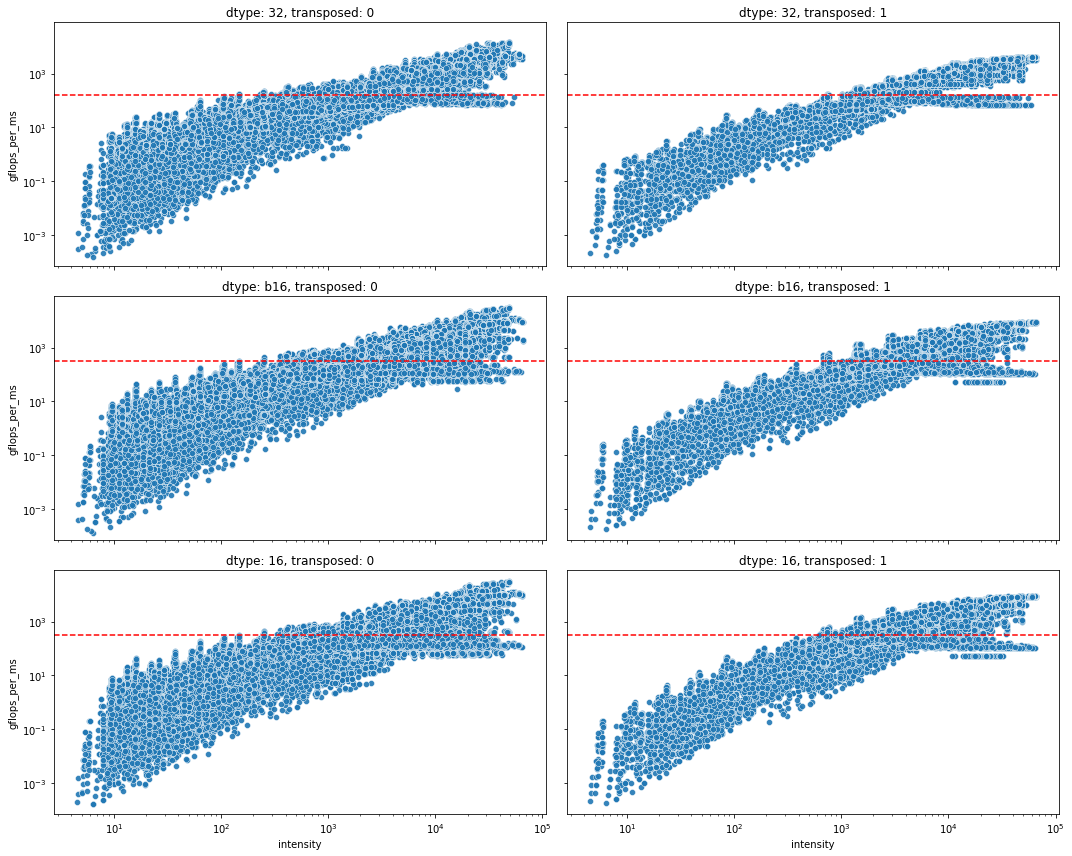

In [6]:

"""
Arithmetic intensity or flops must be computed incorrectly here.
"""

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (dtype, transposed) in enumerate([(dtype, transposed) for dtype in ["32", "b16", "16"] for transposed in [0, 1]]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms", alpha=0.9, data=df.query(f"dtype == '{dtype}' and transposed == '{transposed}'"), ax=ax
    )
    ax.set_title(f"dtype: {dtype}, transposed: {transposed}")

    if dtype == "32":
        dtype = "tf32"
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")
    
# ax.set_xlim(left=10**2, right=10**4)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Weird Conv2d/conv2d backward values

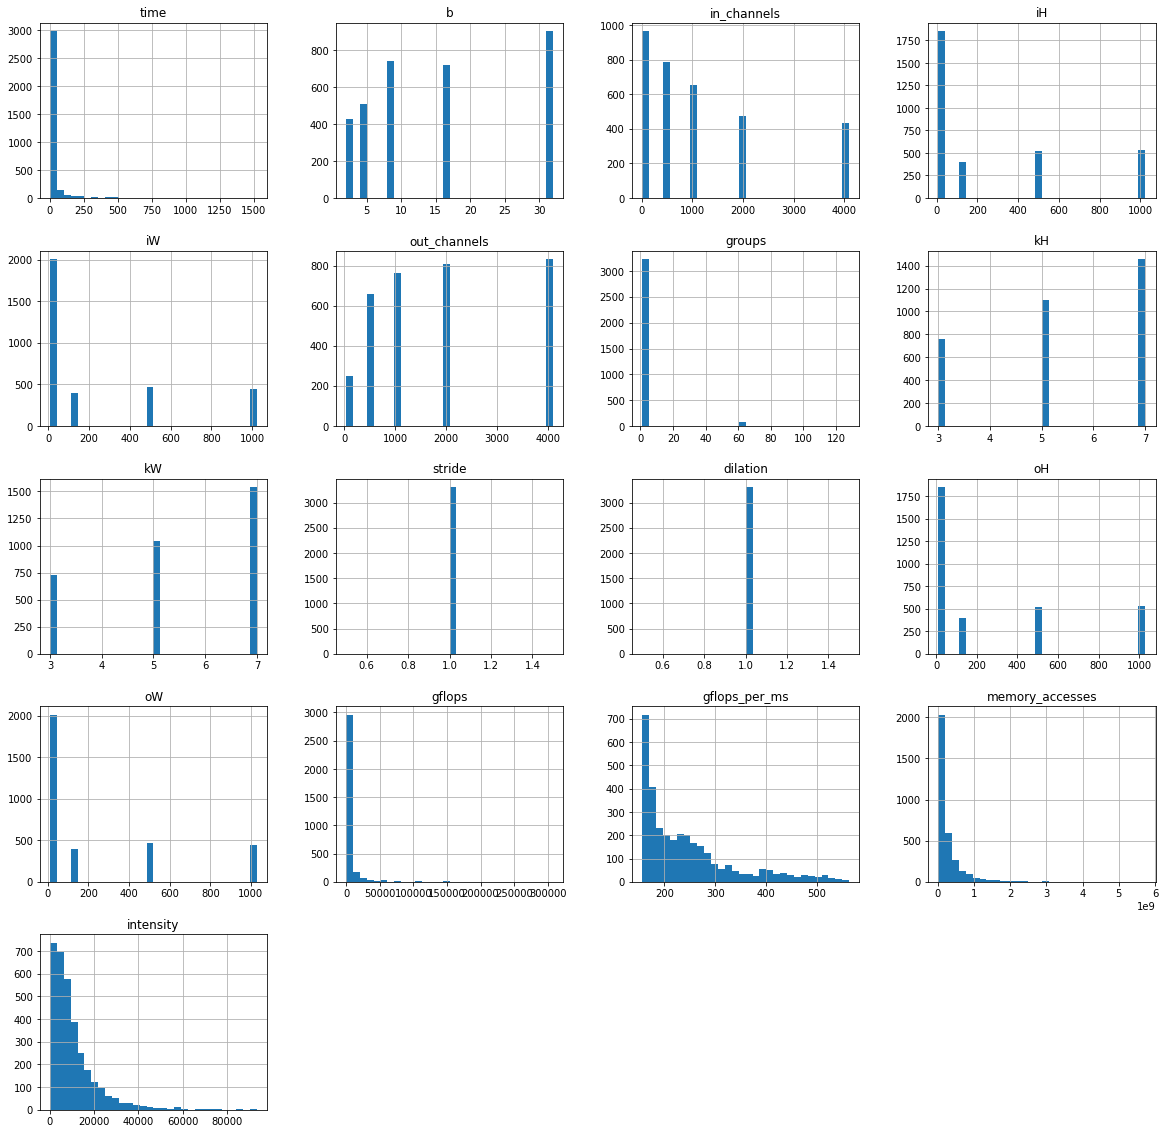

In [30]:
fast = df.query("dtype == '32' and gflops_per_ms > 156")
fast.hist(figsize=(20, 20), bins=30)
plt.show()

In [31]:
fast["gflops_per_ms"].describe()

count    3310.000000
mean      245.773793
std        93.397051
min       156.004930
25%       172.406006
50%       217.397075
75%       280.153907
max       563.714470
Name: gflops_per_ms, dtype: float64

In [32]:
fast.iloc[fast["gflops_per_ms"].argmax()]

kernel_params      32.8.512.8.1024.4096.1.7.3.1.1.0
time                                          10.24
dtype                                            32
b                                                 8
in_channels                                     512
iH                                                8
iW                                             1024
out_channels                                   4096
groups                                            1
kH                                                7
kW                                                3
stride                                            1
dilation                                          1
transposed                                        0
oH                                               14
oW                                             1026
gflops                                  5772.436046
gflops_per_ms                             563.71447
memory_accesses                           548274176
intensity   

In [33]:
(fast["in_channels"] * fast["out_channels"]).describe()

count    3.310000e+03
mean     2.266921e+06
std      3.680192e+06
min      4.096000e+03
25%      2.621440e+05
50%      1.048576e+06
75%      2.097152e+06
max      1.677722e+07
dtype: float64

In [34]:
(fast["iH"] * fast["iW"]).describe()

count     3310.000000
mean      5415.192749
std       6234.363757
min         64.000000
25%       1024.000000
50%       4096.000000
75%       8192.000000
max      32768.000000
dtype: float64

In [35]:
"""
No apparent connection...
"""
fast.gflops.describe()

count      3310.000000
mean       5479.377841
std       17672.420144
min           9.395241
25%         257.698038
50%         858.993459
75%        3367.254360
max      307863.255777
Name: gflops, dtype: float64